# Physics-informed kernel methods

## 1- PDE kernels

### 1.1 - Mathematical setting

**Hybrid modelling.** Here, the goal is to implement the physics-informed kernel to learn a function $f^\star$ such that
* $Y = f^\star(X) + \varepsilon$,
* $f^\star$ is the solution to a PDE

given i.i.d. observations $(X_1,Y_1)$, ..., $(X_n, Y_n)$.

**Fourier expansion.** In the last tutorial, we saw how to create Sobolev kernel on $[0, 0.5]$ by relying on the maps $\phi_m(x) = (\exp(-i 2 \pi k x))_{-m \leq k \leq m}$. Let $m\in \mathbb N^\star$ be the number of Fourier modes. Let $$H_m = \{x\mapsto \sum_{k=-m}^m  \theta_k \exp(i 2 \pi k x), \quad \theta_k \in \mathbb C\} = \{x\mapsto \langle \phi(x), \theta \rangle, \quad \theta_k \in \mathbb C\}$$
be the space of complex-valued trigonometric polynomials of degree at most $m$.

**Question 1.** Assume $d=1$, $\Omega = [0,0.5]$. Find a matrix $C$ such that, for all function $f\in H_m$, $$\int_{0}^{0.5} f(x)^2dx = \theta^* C \theta,$$
where $\theta\in \mathbb C^{2m+1}$ is such that  $f(x) = \langle \phi(x), \theta \rangle$.

**Answer.**
<details>
  <summary>  (Click to show)</summary>
  $$\int_0^{0.5} |f|^2 = \int_0^{0.5} \bar f \times f = \sum_{k_1 = -m}^m \sum_{k_2=-m}^m \bar \theta_{k_1} \theta_{k_2}\int_{0}^{0.5} \exp(i 2\pi (k_2-k_1) x)dx .$$
  Thus, the matrix $C$ is such that $C_{k_1, k_2} = \int_{0}^{0.5} \exp(i 2\pi (k_2-k_1) x)dx$.
  $$\int_{0}^{0.5} \exp(i 2\pi (k_2-k_1) x)dx = \frac{\exp(i \pi (k_2-k_1)) - 1}{i 2 \pi (k_2-k_1)} = \exp(i \pi (k_2-k_1)/2)\frac{\sin(\pi (k_2-k_1)/2)}{\pi (k_2-k_1)}.$$
  Thus, $C$ is a $(2m+1) \times (2m+1)$ complex-valued matrix such that
  $$C_{k_1, k_2} = \exp(i \pi (k_2-k_1)/2)\frac{\sin(\pi (k_2-k_1)/2)}{\pi (k_2-k_1)}.$$

  If $k_1=k_2$, then $C_{k_1, k_2} = 1/2$.
</details>

**Question 2.** Consider the ODE $f'+f = 0$. Find a matrix $M$ such that, for all function $f\in H_m$
$$\int_{0}^{0.5} (f'(x)+f(x))^2dx = \theta^* M \theta,$$
where $\theta\in \mathbb C^{2m+1}$ is such that  $f(x) = \langle \phi(x), \theta \rangle$.

**Answer.**
<details>
  <summary>  (Click to show)</summary>
  We have that $$f'(x) = \sum_{k=-m}^m  \theta_k i 2\pi k \exp(i 2 \pi k x).$$
  Thus, the Fourier coefficient of $f'$ is $D\theta$, where $D$ is the diagonal matrix such that $D_{k,k} =  i 2\pi k$.
  Hence, $(D+I)\theta$ is the Fourier coefficient of $f'+f$.
  Finally, we deduce that $M = (D+I)^* C (D+I)$.  
</details>

**Question 3.** Find the minimizer of the empirical risk
$$L(f) = \frac{1}{n}\sum_{j=1}^n (f(X_i)-Y_i)^2 + \lambda \int_0^{0.5}(f'(x)+f(x))^2dx + \mu \|f\|_{H^1}^2$$
over the space $H_m$, where $\|f\|_{H^2}^2 = \sum_{k=-m}^m|\theta_k|^2(1+k^2)$.

**Answer.**
<details>
  <summary>  (Click to show)</summary>
  The risk can be expressed in terms of $\theta$ as
  $$R(\theta) = \frac{1}{n}\|\Phi \theta - \mathbb Y\|_2^2 + \lambda \theta^* M \theta + \mu \theta^* S \theta,$$
  where

  * $\Phi = \begin{pmatrix}\phi(X_1)^*\\\vdots\\\phi(X_n)^*\end{pmatrix},$
  * $S$ is the diagonal matrix such that $S_{k,k} = (1+k^4)$,
  * $\mathbb Y = \begin{pmatrix}Y_1\\\vdots\\Y_n\end{pmatrix}$.

  $R$ is differentiable, the minimizer of $R$ is obtained by solving $dR(\hat \theta) = 0$. This results in
  $$\hat \theta = (n^{-1} \Phi^* \Phi + \lambda M + \mu S)^{-1} \Phi^* \mathbb Y.$$
  Therefore, the minimizer of $L$ is $\hat f$ defined by $\hat f(x) = \langle \phi(x), \theta\rangle$.
</details>

### 1.2 - Implementing the kernel

In [3]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Question 4.** Create a function *C_matrix* taking as inputs m and the device, and returning the matrix C.

In [6]:
def C_matrix(m, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k, j = torch.meshgrid(fourier_range, fourier_range, indexing='ij')
  diff = (j-k).flatten()

  T_values = torch.where(diff == 0, 1/2, 0.) + torch.where(diff != 0, torch.exp(1j*torch.pi*diff/2)*torch.sin(torch.pi*diff/2)/diff/torch.pi, 0.)


  return T_values.view(2*m+1, 2*m+1)

**Question 5.** Create a function *M_matrix* taking as inputs m and the device, and returning the matrix $M$.

In [8]:
def D_matrix(m, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k, j = torch.meshgrid(fourier_range, fourier_range, indexing='ij')
  diff = (j-k).flatten()

  C_values =  torch.where(k == j, 1j*2*torch.pi*k, 0.)

  return C_values.view(2*m+1, 2*m+1)

def dagger(matrix):
  return matrix.conj().T

def M_matrix(m, device):
  C_mat = C_matrix(m, device)
  D_mat = D_matrix(m, device)
  I_mat = torch.eye(2*m+1, device=device)
  return dagger(D_mat+I_mat) @ C_mat @ (D_mat+I_mat)

**Question 7.** Create a function *S_matrix* taking as inputs m and the device, and returning the matrix $S$.

In [12]:
def S_matrix(m, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k, j = torch.meshgrid(fourier_range, fourier_range, indexing='ij')
  S_mat = torch.where(k == j, 1+ k**2, 0.)
  return S_mat

**Question 8.** Create a function *phi_matrix* taking as inputs m and the device, and returning the matrix $\Phi$.

In [54]:
def phi_matrix(x, m):
  n = x.shape[0]
  x_matrix = torch.tile(x.view(-1,1), (1, 2*m+1))
  k_matrix = torch.tile(torch.arange(-m, m+1, device=device), (n, 1))
  return torch.exp(1j*2*torch.pi*torch.multiply(k_matrix,x_matrix))

**Question 9.** Implement a function *generate_data* taking as inputs

* the number $n$ of training points,
* the standard deviation $\sigma$ of the noise

and returns as outputs

* a tensor of shape (n) encoding the features $(X_1, \dots, X_n)$
* a tensor of shape (n,1) encoding the features $(Y_1, \dots, Y_n)$ such that $Y_i = f^\star(X_i)+\sigma N(0,1)$.

In this example, sample $X_i$ uniformely on $[0, 0.5]$ and take $f^\star(x) = 2\exp(-x)$ is a solution of the ODE $f'+f = 0$.

In [45]:
def generate_data(n, sigma, device):
  x = torch.rand(n, device=device) * 0.5
  y = 2*torch.exp(-x) + sigma * torch.randn(n, device=device)
  return x, y.view(-1,1)

**Question 10.** Implement a function *hat_theta* taking as inputs

* the hyperparameters $\lambda$ and $\mu$,
* the maximum frequency $m$ of the Fourier modes,
* the training feature vector $x$,
* the training target vector $y$,

and returns the vector $\hat \theta$.

In [83]:
def hat_theta(lamb, mu, m, x, y, device):
  C_mat = C_matrix(m, device)
  M_mat = M_matrix(m, device)
  S_mat = S_matrix(m, device)

  phi_mat = phi_matrix(x, m)
  n = x.shape[0]
  dagger_phi = dagger(phi_mat)
  theta = torch.linalg.solve( dagger_phi @ phi_mat/n + lamb* M_mat + mu * S_mat, dagger(phi_mat) @ torch.complex(y, 0*y)/n)
  return theta


**Question 11.** Evaluate the performance of the kernel method with $n = 10$ with physics ($\lambda = 1$) and without physics ($\lambda = 0$). Set $m=100$, $\sigma = 0.1$, and $\mu = 10^{-2}$.

In [105]:
m = 100
n = 10
sigma = 0.1
mu = 10**-2

# Training data generation
torch.manual_seed(1)
x_train, y_train = generate_data(n, sigma, device)

# Training models
theta_piml = hat_theta(1, mu, m, x_train, y_train, device)
theta_data_driven = hat_theta(0, mu, m, x_train, y_train, device)

# Test data generation
x_test = torch.linspace(0, 0.5, 100, device=device)
ground_truth = 2*torch.exp(-x_test)

# MSE
phi_test = phi_matrix(x_test, m)

y_data_driven = torch.real(phi_test@theta_data_driven).flatten()
y_piml = torch.real(phi_test@theta_piml).flatten()

mse_data_driven = torch.mean((y_data_driven - ground_truth)**2).item()
mse_piml = torch.mean((y_piml - ground_truth)**2).item()

print("MSE without physics ", mse_data_driven)
print("MSE with physics ", mse_piml)

MSE without physics  0.027835335582494736
MSE with physics  0.0005897339433431625


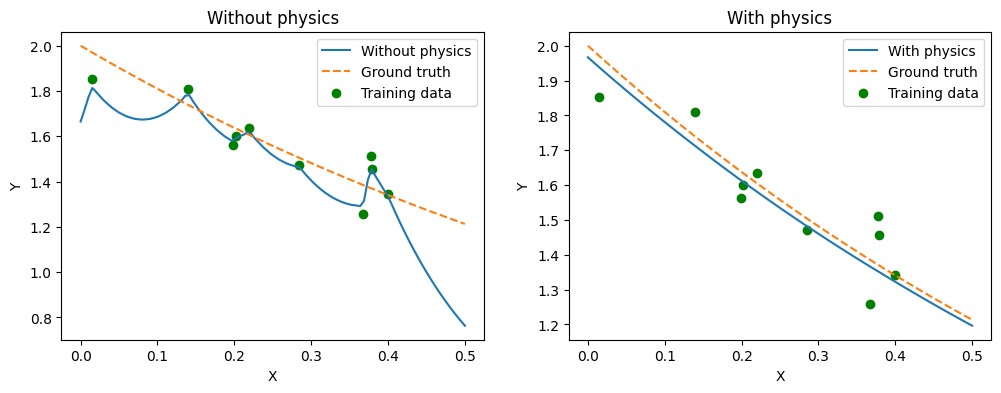

In [113]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# --- Subplot 1: Training Data
axs[0].plot(x_test, y_data_driven, label="Without physics")
axs[0].plot(x_test, ground_truth, label="Ground truth", linestyle = "--")
axs[0].scatter(x_train, y_train, label="Training data", color = "green")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].legend()
axs[0].set_title("Without physics")

# --- Subplot 1: Training Data
axs[1].plot(x_test, y_piml, label="With physics")
axs[1].plot(x_test, ground_truth, label="Ground truth", linestyle = "--")
axs[1].scatter(x_train, y_train, label="Training data", color = "green")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].legend()
axs[1].set_title("With physics")

plt.show()

## 2- Pikernel package


### 2.1 Downloading the package

The *pikernel* package implements an optimized version of the algorithm from the papers

* *Physics-informed machine learning as a kernel method*, COLT (2024)
* *Physics-informed kernel learning*, In review (2024).

**Question 12.** Install the package by running the following command. Go to the pip repository [https://pypi.org/project/pikernel/](https://pypi.org/project/pikernel/) and read the minimal examples in dimension 1 and 2.

In [2]:
pip install pikernel

### 2.2 ODE with a driving term

**Question 13.** Using the *pikernel* package, how would you design an algorithm taking into account the ODE a priori $$f'(x) + f(x) = x^2?$$

**Answer.**
<details>
  <summary>  (Click to show)</summary>

  **Superposition principle.** The superposition principle states that $f$ is a solution to the ODE $f'(x) + f(x) = x^2$ if and only if

  * $f - g$ is a solution to the homogeneous ODE $(f-g)'(x) + (f-g)(x) = 0$,
  * where $g$ is a particular solution to the ODE $g'(x) + g(x) = x^2$.

  We look for a solution $g$ of the form $g(x) =  bx^2 +cx + d$. The ODE $g'(x) + g(x) = x^2$ implies that

  * b = 1
  * 2b + c = 0
  * c + d = 0.


  Thus, $c = -d$, $b = 1 = -c/2 = d/2$, leading to $g(x) = x^2 -2x + 2$.

  **Conclusion.** Thus, we know that $f^\star - g$ is a solution to the homogeneous ODE $(f-g)'(x) + (f-g)(x) = 0$. We only need to learn $f^\star - g$ from the data $(X_1, Y_1 - g(X_1)), \dots, (X_n, Y_n - g(X_n))$.

</details>

**Question 14.** Implement this algorithm with
* $f^\star(x) = \exp(-x) + x^2 - 2x +2$,
* $X$ following the uniform distribution on $[-1, 1]$,  
* $\varepsilon$ being a gaussian noise of distribution $ N(0,1)$,
* $n = 10^3$, $\lambda_n = 1/n$, and $\mu_n = 1$,
* $s = 3$,
* $m = 10^2$ Fourier modes.

In [4]:
from pikernel.utils import find_device
from pikernel.kernel import PikernelModel
from pikernel.dimension_1 import dX

# Set a seed for reproducibility of the results
torch.manual_seed(1)

# dX is the differential operator d/dx
# Define the ODE: f' + f = 0
dimension = 1
ODE = 1 + dX

# Parameters
device = find_device() # Automatically detects GPU, or CPU
sigma = 1              # Noise standard deviation
s = 3                  # A priori smoothness of the solution
L = 1                  # Domain where the ODE holds: [-L, L]
n = 10**3              # Number of training samples
m = 10**2              # Number of Fourier features
l = 10**3              # Number of test points

# Generate the training data
x_train = torch.rand(n, device=device) * 2 * L - L
y_train = torch.exp(-x_train) + x_train**2 - 2*x_train + 2 + sigma * torch.randn(n, device=device)

# Generate the test data
x_test = torch.rand(l, device=device) * 2 * L - L
ground_truth = torch.exp(-x_test) + x_test**2 - 2*x_test + 2

# Regularization parameters
lambda_n = 1 / n    # Smoothness hyperparameter
mu_n = 1            # PDE hyperparameter

# Computation of g
g_train = x_train**2 - 2*x_train + 2
g_test = x_test**2 - 2*x_test + 2

# Computation of diff = Y - g(X)
diff_train = y_train - g_train

# Fit model using the ODE constraint
kernel_model = PikernelModel(dimension, L, ODE, device)
kernel_model.fit(x_train, diff_train, s, m, lambda_n, mu_n, n)

# Predict on test data
diff_pred = kernel_model.predict(x_test)
y_pred = diff_pred + g_test

# Compute the mean squared error
mse = kernel_model.mse(y_pred, ground_truth)
print(f"MSE = {mse}")

The algorithm is not running on GPU.
MSE = 0.0027328837316565042


### 2.3 Extrapolation using a PDE with a driving term

**Question 15.** How would you use the *pikernel* package to learn the a function satisfying the Poisson PDE $$\partial_1^2 f(x_1, x_2) + \partial_2^2 f(x_1, x_2) = \cos(x_1)?$$

**Answer.**
<details>
  <summary>  (Click to show)</summary>

  **Superposition principle.** The superposition principle states that $f$ is a solution to the ODE $\partial_1^2 f(x_1, x_2) + \partial_2^2 f(x_1, x_2) = \cos(x_1)$ if and only if

  * $f - g$ is a solution to the homogeneous ODE $\partial_1^2 (f-g) + \partial_2^2 (f-g) = 0$,
  * where $g$ is a particular solution to the ODE $\partial_1^2 g(x_1, x_2) + \partial_2^2 g(x_1, x_2) = \cos(x_1)$.


  The function $g(x_1, x_2) =  -\cos(x_1)$ works.


  **Conclusion.** Thus, we know that $f^\star - g$ is a solution to the Laplace equation  $\partial_1^2 (f-g) + \partial_2^2 (f-g) = 0 = 0$. We only need to learn $f^\star - g$ from the data $(X_1, Y_1 - g(X_1)), \dots, (X_n, Y_n - g(X_n))$.

</details>

**Question 16.** Implement this algorithm with
* $f^\star(x_1, x_2) = 1-x_1+x_2-\cos(x_1)$,
* $X_1$ and $X_2$ being independent and following the uniform distribution on $[-0.5, 0.5]$,  
* $\varepsilon$ being a gaussian noise of distribution $ N(0,1)$,
* $n = 10^3$, $\lambda_n = n^{-2/3}$, and $\mu_n = 1$,
* $s = 2$,
* $m = 10$ Fourier modes.

Though the training data are sampled in $[0.5, 0.5]^2$, we assume that the PDE is satified over the whole disk $D = \{x_1^2 + x_2^2 \leq 1\}$.
Evaluate the performance of the kernel method in extrapolation on $D$, by computing its MSE on with $X_1^{(test)}$ and $X_2^{(test)}$ sampled on $D$. Take $(X_1^{(test)},\; X_2^{(test)}) = (R\cos(\theta),\; R\sin(\theta))$ such that  $R$ follows the uniform distribution on $[0,1]$ and $\theta$ follows the uniform distribution on $[0,2\pi]$.

Compare the performance of the Physics-informed kernel ($\mu_n = 1$) and the Sobolev kernel ($\mu_n = 0$).

In [72]:
from pikernel.utils import find_device
from pikernel.kernel import PikernelModel
from pikernel.dimension_2 import dX_1, dX_2

# Set seed for reproducibility
torch.manual_seed(1)

# Define the heat equation PDE: d/dx - d^2/dy^2
dimension = 2
PDE = dX_1**2 + dX_2**2

# Parameters
device = find_device()   # Automatically detects GPU, or CPU
sigma = 0.1              # Noise standard deviation
s = 2                    # Smoothness of the solution
L = 1                    # The domain is a subset of [-L, L]^2
domain = "disk"          # Domain's shape
m = 10                 # Number of Fourier features in each dimension
n = 10**3                # Number of training points
l = 10**4                # Number of testing points

# Generate the training data
x1_train = torch.rand(n, device=device)-0.5
x2_train = torch.rand(n, device=device)-0.5
x_train = [x1_train, x2_train]
y_train = 1+ x1_train - x2_train - torch.cos(x1_train) + sigma * torch.randn(n, device=device)

# Generate the test data
r_test = torch.rand(l, device=device)
theta_test = torch.rand(l, device=device)*2*np.pi
x1_test = r_test*torch.cos(theta_test)
x2_test = r_test*torch.sin(theta_test)
x_test = [x1_test, x2_test]
ground_truth =  1+ x1_test - x2_test - torch.cos(x1_test)

# Computation of g
g_train = -torch.cos(x1_train)
g_test = -torch.cos(x1_test)

# Computation of diff = Y - g(X)
diff_train = y_train - g_train


## Physics-informed kernel
# Regularization parameters
lambda_n = n**(-2/3)   # Smoothness hyperparameter
mu_n = 1        # PDE hyperparameter

# Fit model using the PDE constraint
kernel_model = PikernelModel(dimension, L, PDE, device)
kernel_model.fit(x_train, diff_train, s, m, lambda_n, mu_n, n)

# Predict on test data
diff_pred = kernel_model.predict(x_test)
y_pred_pi = diff_pred + g_test

# Compute the mean squared error
mse = kernel_model.mse(y_pred_pi, ground_truth)
print("Physics-informed MSE = ", mse)

## Sobolev kernel
# Regularization parameters
lambda_n = n**(-2/3)    # Smoothness hyperparameter
mu_n = 0                # PDE hyperparameter

# Fit model using the PDE constraint
kernel_model = PikernelModel(dimension, L, PDE, device)
kernel_model.fit(x_train, y_train, s, m, lambda_n, mu_n, n)

# Predict on test data
y_pred = kernel_model.predict(x_test)

# Compute the mean squared error
mse = kernel_model.mse(y_pred, ground_truth)
print("Sobolev MSE = ", mse)

The algorithm is not running on GPU.
Physics-informed MSE =  0.001635407975470814
Sobolev MSE =  0.06028834988987381


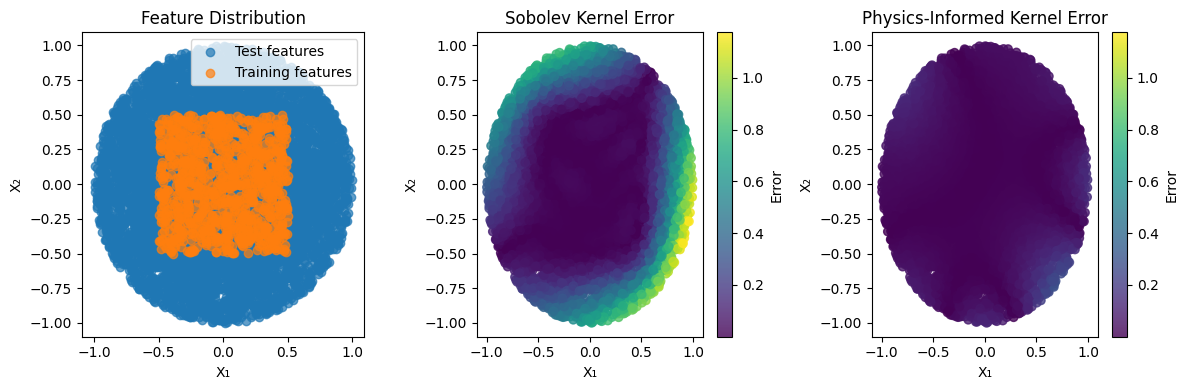

In [77]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# --- Subplot 1: Feature Distribution ---
axs[0].scatter(x1_test, x2_test, label="Test features", alpha=0.7)
axs[0].scatter(x1_train, x2_train, label="Training features", alpha=0.7)
axs[0].set_xlabel("X₁")
axs[0].set_ylabel("X₂")
axs[0].set_title("Feature Distribution")
axs[0].legend()

# Compute errors
error_sobolev = torch.abs(y_pred - ground_truth)
error_pi = torch.abs(y_pred_pi - ground_truth)

# Determine common color scale
min_error = torch.min(torch.cat([error_sobolev, error_pi])).item()
max_error = torch.max(torch.cat([error_sobolev, error_pi])).item()

# --- Subplot 2: Error of Sobolev Kernel ---
sc1 = axs[1].scatter(x1_test, x2_test, c=error_sobolev, cmap='viridis', alpha=0.8,
                     vmin=min_error, vmax=max_error)
axs[1].set_xlabel("X₁")
axs[1].set_ylabel("X₂")
axs[1].set_title("Sobolev Kernel Error")
fig.colorbar(sc1, ax=axs[1], label='Error')

# --- Subplot 3: Error of Physics-Informed Kernel ---
sc2 = axs[2].scatter(x1_test, x2_test, c=error_pi, cmap='viridis', alpha=0.8,
                     vmin=min_error, vmax=max_error)
axs[2].set_xlabel("X₁")
axs[2].set_ylabel("X₂")
axs[2].set_title("Physics-Informed Kernel Error")
fig.colorbar(sc2, ax=axs[2], label='Error')

# Showing the plots
plt.tight_layout()
plt.show()


The physics-informed kernel clearly extrapolates way better than the Sobolev kernel.